In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import os
import wes
import sys
sys.path.append('/home/avic/Rotation-Generalization')
from tools import *

In [2]:
X = "Rotating on γ\n"
Y = "Rotating on β\n"
Z = "Rotating on α\n"
HOLE = f"{Z}(γ ≈ π/2)"
HOLE_CENTER = f"{Z}(γ ≈ 0 ⋃ γ ≈ π/2)"
def translate_axes_scheme(unrestricted_axis, hole):
    if hole == 0:
        return [X, Y, Z][unrestricted_axis]
    elif hole == 1:
        return HOLE
    else:
        return HOLE_CENTER
def translate_training_type(training_type, testing_type=None):
    if testing_type == None or training_type == testing_type:
        if training_type == "plane":
            return "Airplane"
        if training_type == "car":
            return "Car"
        if training_type == 'lamp':
            return "Lamp"
        if training_type == 'SM':
            return training_type
        print('error')
        return
    if training_type == 'plane':
        return "Airplane→SM"
    if training_type == 'SM':
        return "SM→Airplane"
    print('error')
    return
def translate_model_type(model_type):
    return model_type[10:]
def translate_component_type(component_type):
    component_title = component_type[:-4]
    if component_title == 'A':
        return 'A (Small Angle)'
    if component_title == 'E':
        return 'E (In-Plane)'
    if component_title == 'AE':
        return 'AE (Small Angle, \n       In-Plane)'
def translate_exp_type(exp):
    if exp.augment:
        return 'Data Augmentation'
    if exp.pretrained:
        return 'Pretrained'
    if exp.scale:
        return 'Scaled'
    return 'From Scratch'
def translate_scale_index(scale_index):
    
    return f'{round(0.65 + (0.07 * scale_index), 3)} - {round(0.72 + (scale_index * 0.07), 3)}'

In [30]:
def get_merged_frames(i, n, t=None):
#     fits = pd.read_csv(f'~/Rotation-Generalization/fits/exp{n}_fits_scale.csv', index_col=[0,1,3])
#     averages = pd.read_csv(f'~/Rotation-Generalization/averages/exp{n}_averages_scale.csv', index_col=[0,1,2])
#     exps = pd.read_csv(f'~/Rotation-Generalization/exps{n}.csv', index_col=[5,2])
#     exps = pd.read_csv(f'~/Rotation-Generalization/exps{1}.csv').merge(pd.DataFrame({'scale_index':[0,1,2,3,4]}), how='cross').set_index(['num','data_div','scale_index'])
#     exps = exps[exps.scale]
#     joined_subset = exps.join(fits, on=['num', 'data_div', 'scale_index'], rsuffix='fits')
#     joined_subset = joined_subset.join(averages, on=['num', 'data_div', 'scale_index'], rsuffix='avgs')
    fits = pd.read_csv(f'~/Rotation-Generalization/fits/exp{n}_fits.csv', index_col=[0,1])
    averages = pd.read_csv(f'~/Rotation-Generalization/averages/exp{n}_averages.csv', index_col=[0,1])
    exps = pd.read_csv(f'~/Rotation-Generalization/exps{n}.csv', index_col=[5,2])
    joined_subset = exps.join(fits, on=['num', 'data_div'], rsuffix='fits')
    joined_subset = joined_subset.join(averages, on=['num', 'data_div'], rsuffix='avgs')
    joined_subset['exp_iter'] = i
    if t is not None:
        joined_subset['Training Condition'] = t
    return joined_subset

In [45]:
def get_joined():
    joined = get_merged_frames('half', '_half', 'Half Data')
    joined = pd.concat([joined] + [get_merged_frames(i, n, 'All Data') for i, n in enumerate(range(1,4))]).reset_index()

#     joined = pd.concat([get_merged_frames(i, n) for i, n in enumerate(range(1,4))]).reset_index()

    joined = joined[joined.model_type.isin(['ModelType.ResNet', 'ModelType.DenseNet', 'ModelType.Inception', 'ModelType.CorNet'])]
    joined = joined[np.sum(np.array([(joined.augment).to_numpy(dtype=np.int), (joined.pretrained).to_numpy(dtype=np.int), (joined.scale).to_numpy(dtype=np.int)]), axis=0) <= 1]
    joined['axes_scheme'] = [translate_axes_scheme(exp.unrestricted_axis, exp.hole) for _, exp in joined.iterrows()]
    joined['training_category'] = [translate_training_type(exp.training_category, exp.testing_category) for _, exp in joined.iterrows()]
    joined['model_type'] = [translate_model_type(exp.model_type) for _, exp in joined.iterrows()]
    joined['exp_type'] = [translate_exp_type(exp) for _, exp in joined.iterrows()]
    joined.rename(columns={'model_type': 'Architecture', 'id_average': 'In Distribution', 'ood_average': 'Out of Distribution'}, inplace=True)
    return joined

/home/avic/om5/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/avic/om5/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:375: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/home/avic/om5/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout()


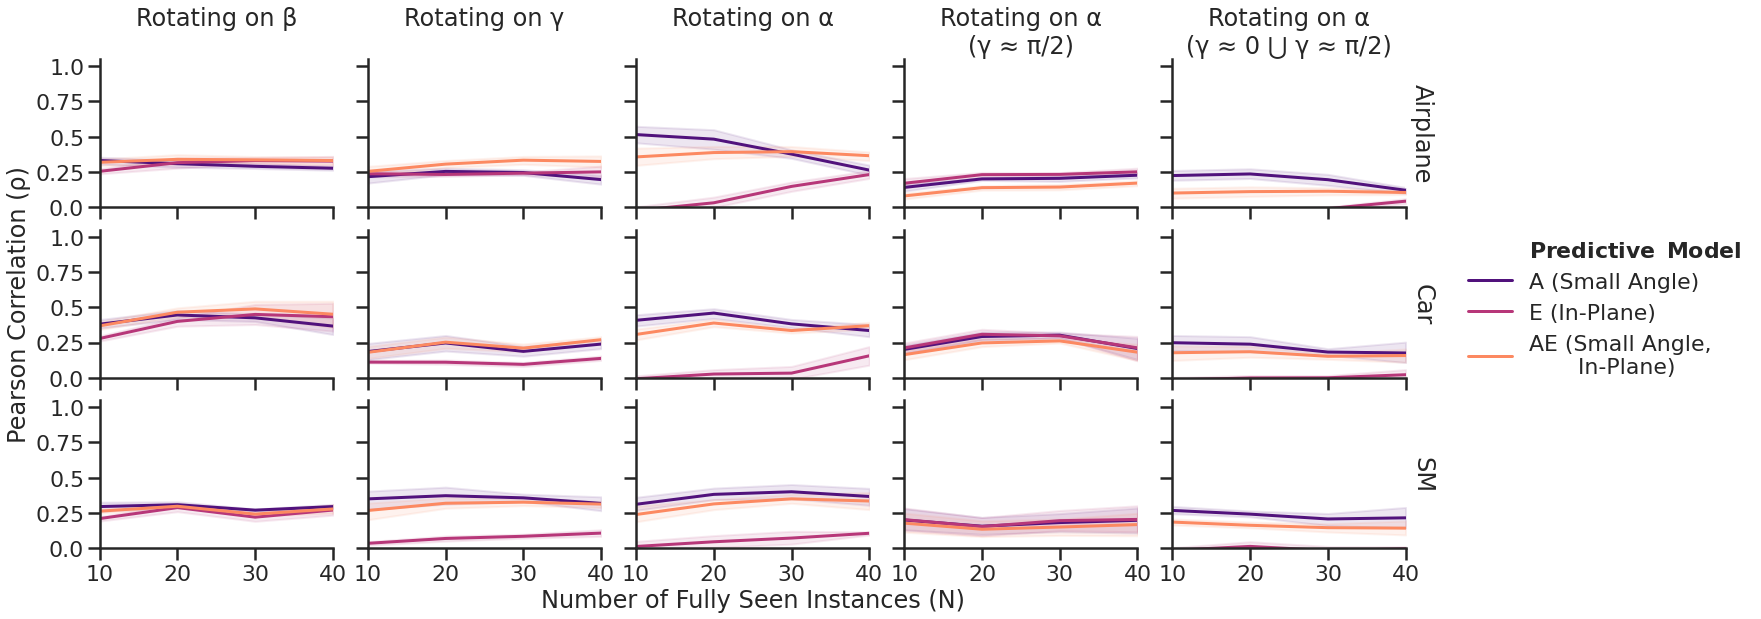

In [15]:
joined = get_joined()
p = '/home/avic/Rotation-Generalization/notebooks/figures/pearson'

'''
0: Architectures
1: Cross
2: Pretrained
3: Augmented
4: Half
5: Lamp
6: Scale
'''
fig_type = 6
if fig_type == 0:
    joined = joined[~joined.pretrained & ~joined.augment & ~joined.scale].reset_index()
    FIGURE_PATH = os.path.join(p, 'architectures')
elif fig_type == 1:
    joined = joined[~joined.pretrained & ~joined.augment & ~joined.scale].reset_index()
    FIGURE_PATH = os.path.join(p, 'cross')
elif fig_type == 2:
    joined = joined[joined.pretrained & ~joined.augment & ~joined.scale].reset_index()
    FIGURE_PATH = os.path.join(p, 'pretrained')
elif fig_type == 3:
    joined = joined[~joined.pretrained & joined.augment & ~joined.scale].reset_index()
    FIGURE_PATH = os.path.join(p, 'augment')
elif fig_type == 4:
    joined = joined[~joined.pretrained & ~joined.augment & ~joined.scale].reset_index()
    FIGURE_PATH = os.path.join(p, 'half')
elif fig_type == 5:
    joined = joined[~joined.pretrained & ~joined.augment & ~joined.scale].reset_index()
    FIGURE_PATH = os.path.join(p, 'lamp')
elif fig_type == 6:
    joined = joined[~joined.pretrained & ~joined.augment & joined.scale].reset_index()
    joined = joined[(joined.scale_index.isin([1,3]))]
    joined['scale_index'] = [translate_scale_index(exp.scale_index) for _, exp in joined.iterrows()]
    FIGURE_PATH = os.path.join(p, 'scale')
    
if fig_type == 5:
    ROW_ORDER = ['Lamp']
elif fig_type != 1:
    ROW_ORDER = ['Airplane', 'Car', 'SM']
else:
    ROW_ORDER = ["Airplane→SM", "SM→Airplane"]

if fig_type != 0:
    ARCHITECTURES = ['ResNet'] 
    joined = joined[joined.Architecture == 'ResNet']
else:
    ARCHITECTURES = ['ResNet', 'DenseNet', 'Inception', 'CorNet']


os.makedirs(FIGURE_PATH, exist_ok=True)
melted_subset = pd.melt(joined.reset_index(), id_vars=['job_id', 'data_div', 'num', 'axes_scheme', 'Architecture', 'training_category', 'unrestricted_axis', 'exp_iter'], value_vars=['A_fit', 'E_fit', 'AE_fit'])
melted_subset.rename(columns={'variable':'Predictive Model C'})
melted_subset['Predictive Model C'] = [translate_component_type(exp.variable) for _, exp in melted_subset.iterrows()]
sns.set_style("dark")
sns.set_context("poster")
sns.set_style("ticks")
for model_type in ARCHITECTURES:
    g = sns.FacetGrid(melted_subset[(melted_subset.Architecture == model_type)], col="axes_scheme",  row="training_category", xlim=(10,40), ylim=(0,1.05), margin_titles=True, gridspec_kws={"wspace":0.15, "hspace":0.15}, size=3, aspect=1.5, col_order=[Y, X, Z, HOLE, HOLE_CENTER], row_order=ROW_ORDER)
    lps = g.map_dataframe(sns.lineplot, "data_div", "value", hue="Predictive Model C", palette=sns.color_palette("magma", 3), err_kws={"alpha": .1})
    plt.xticks(range(10,50,10))
    plt.yticks([0.25 * i for i in range(5)], [f'{0.25 * i}' for i in range(5)])
    [plt.setp(ax.texts, text="") for ax in g.axes.flat]
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
    [g.axes[len(ROW_ORDER)-1,x].set_xlabel('' if x != 2 else "Number of Fully Seen Instances (N)") for x in range(5)]
    [g.axes[y,0].set_ylabel('' if y != len(ROW_ORDER) // 2 else f"{'                         ' if fig_type == 1 else ''}Pearson Correlation (ρ)") for y in range(len(ROW_ORDER))]
    g.add_legend()
    g._legend.texts[0].set_text(r"$\bf{Predictive \hspace{0.5} Model}$")
    plt.savefig(os.path.join(FIGURE_PATH, model_type + '.png'), dpi=200, bbox_inches='tight')

/home/avic/om5/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/avic/om5/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:375: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/home/avic/om5/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout()


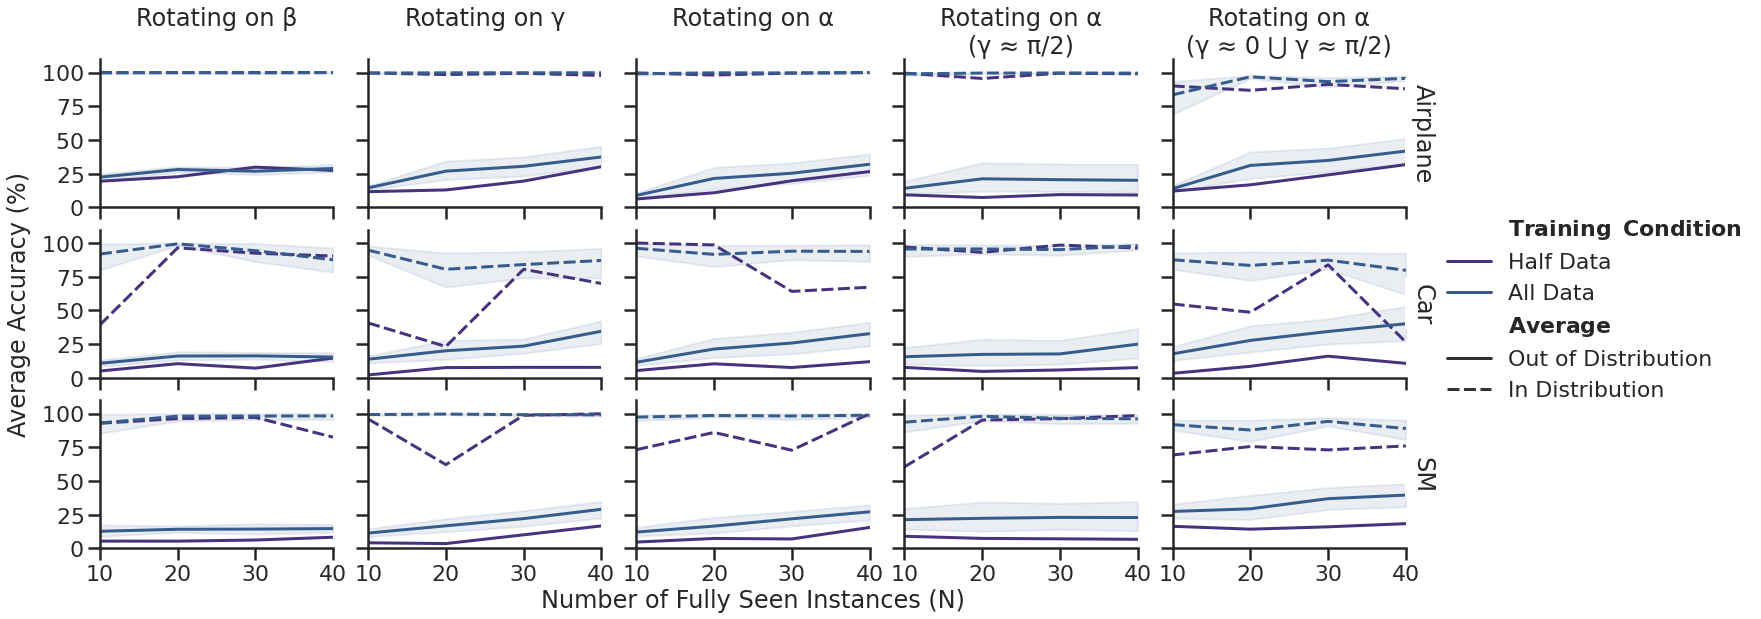

In [46]:
joined = get_joined()
FIGURE_PATH = '/home/avic/Rotation-Generalization/notebooks/figures/averages'
os.makedirs(FIGURE_PATH, exist_ok=True)

'''
0: ResNet Control
1: Architectures
2: Pretrained
3: Augmented
4: Half
5: Lamp
'''
fig_type = 4
if fig_type == 0:
    joined = joined[~joined.scale].reset_index()
    FILE_NAME = 'resnet_control'
if fig_type == 1:
    joined = joined[~joined.pretrained & ~joined.augment & ~joined.scale].reset_index()
    FILE_NAME = 'architectures'
elif fig_type == 2:
    joined = joined[joined.pretrained & ~joined.augment & ~joined.scale].reset_index()
    FILE_NAME = 'pretrained'
elif fig_type == 3:
    joined = joined[~joined.pretrained & joined.augment & ~joined.scale].reset_index()
    FILE_NAME = 'augment'
elif fig_type == 4:
    joined = joined[~joined.pretrained & ~joined.augment & ~joined.scale].reset_index()
    FILE_NAME  = 'half'
elif fig_type == 5:
    joined = joined[~joined.pretrained & ~joined.augment & ~joined.scale].reset_index()
    FILE_NAME = 'lamp'
elif fig_type == 6:
    joined = joined[~joined.pretrained & ~joined.augment & joined.scale].reset_index()
    joined = joined[(joined.scale_index.isin([1,3]))]
    joined['scale_index'] = [translate_scale_index(exp.scale_index) for _, exp in joined.iterrows()]
    FIGURE_PATH = os.path.join(p, 'scale')
    
LEGEND_1_TITLE = 'Training Condition'
if fig_type == 4:
    HUE = 'Training Condition'
elif fig_type == 1:
    LEGEND_1_TITLE = 'Architecture'
    HUE = 'Architecture'
else:
    HUE = 'exp_type'
    
if fig_type == 1:
    sns.set_style("ticks")
    sns.set_palette('husl')
else:
    sns.set_style("ticks")
    sns.set_palette('viridis')
    
    
if fig_type == 4:
    melted_joined = pd.melt(joined, id_vars=['job_id', 'data_div', 'num', 'axes_scheme', 'Architecture', 'training_category', 'unrestricted_axis', 'exp_iter', 'exp_type', 'Training Condition'], value_vars=["In Distribution", "Out of Distribution"])
else:
    melted_joined = pd.melt(joined, id_vars=['job_id', 'data_div', 'num', 'axes_scheme', 'Architecture', 'training_category', 'unrestricted_axis', 'exp_iter', 'exp_type'], value_vars=["In Distribution", "Out of Distribution"])

if fig_type == 5:
    ROW_ORDER = ['Lamp']
else:
    ROW_ORDER = ['Airplane', 'Car', 'SM']

# if fig_type == 1:
#     FILE_NAME = 'scale'
#     LEGEND_1_TITLE = 'Scale'
#     joined['scale_index'] = [translate_scale_index(exp.scale_index) for _, exp in joined.iterrows()]
#     HUE = 'scale_index'
# ROW_ORDER = ['Airplane', 'Car', 'SM'] #["Airplane → SM", "SM → Airplane"]
LEGEND_2_TITLE = 'Average'
def get_title(title):
    spaces_added = '\hspace{0.5}'.join(title.split(' '))
    return fr"$\bf{spaces_added}$"
sns.set_style("dark")
sns.set_context("poster")
sns.set_style("ticks")
# sns.set_palette(np.array(sns.color_palette())[::-1])
g = sns.FacetGrid(melted_joined, col="axes_scheme", row='training_category', xlim=(10,40), ylim=(0,1.1), margin_titles=True, gridspec_kws={"wspace":0.15, "hspace":0.15}, size=3, aspect=1.5, col_order=[Y, X, Z, HOLE, HOLE_CENTER], row_order=ROW_ORDER)
lps = g.map_dataframe(sns.lineplot, "data_div", "value", style='variable', style_order=['Out of Distribution', 'In Distribution'], hue=HUE, err_kws={"alpha": .1})
plt.xticks(range(10,50,10))
plt.yticks([0.25 * i for i in range(5)], [f' {25 * i}' for i in range(5)])
[plt.setp(ax.texts, text="") for ax in g.axes.flat]
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
[g.axes[len(joined[HUE].unique()) - 0,x].set_xlabel('' if x != 2 else "Number of Fully Seen Instances (N)") for x in range(5)]
[g.axes[y,0].set_ylabel('' if y != len(ROW_ORDER) // 2 else "Average Accuracy (%)") for y in range(len(ROW_ORDER))]
g.add_legend()
g._legend.texts[0].set_text(get_title(LEGEND_1_TITLE))
g._legend.texts[len(joined[HUE].unique()) + 1].set_text(get_title(LEGEND_2_TITLE))
plt.savefig(os.path.join(FIGURE_PATH, f'{FILE_NAME}.png'), dpi=200, bbox_inches='tight')

/home/avic/om5/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/avic/om5/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:375: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/home/avic/om5/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout()


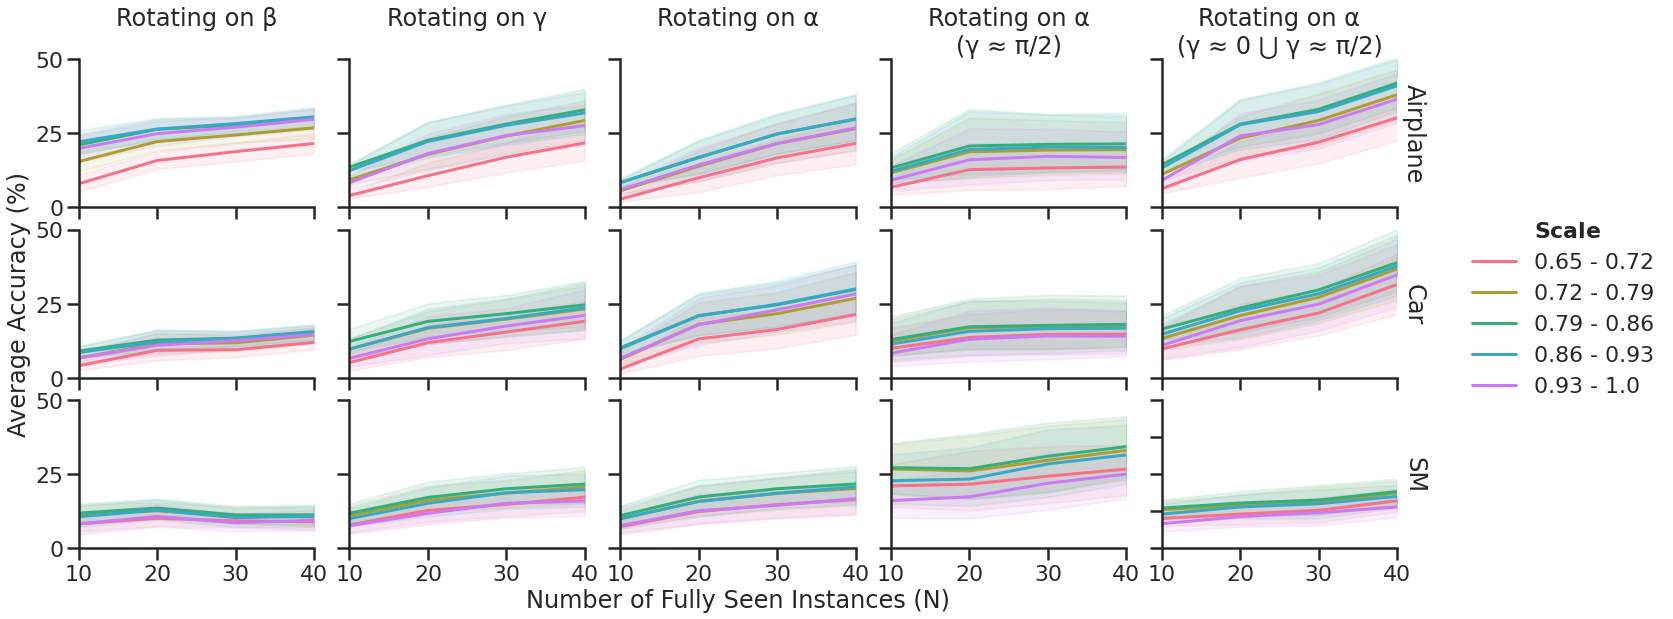

In [17]:
joined = get_joined()
FIGURE_PATH = '/home/avic/Rotation-Generalization/notebooks/figures/averages'
os.makedirs(FIGURE_PATH, exist_ok=True)
joined = joined[~joined.pretrained & ~joined.augment & joined.scale].reset_index()
joined['scale_index'] = [translate_scale_index(exp.scale_index) for _, exp in joined.iterrows()]
FILE_NAME = 'scale'
HUE = 'scale_index'
LEGEND_1_TITLE = 'Scale'
    
ROW_ORDER = ['Airplane', 'Car', 'SM']

LEGEND_2_TITLE = 'Average'
def get_title(title):
    spaces_added = '\hspace{0.5}'.join(title.split(' '))
    return fr"$\bf{spaces_added}$"

sns.set_style("dark")
sns.set_context("poster")
sns.set_style("ticks")

g = sns.FacetGrid(joined, col="axes_scheme", row='training_category', xlim=(10,40), ylim=(0,0.5), margin_titles=True, gridspec_kws={"wspace":0.15, "hspace":0.15}, size=3, aspect=1.5, col_order=[Y, X, Z, HOLE, HOLE_CENTER], row_order=ROW_ORDER)
lps = g.map_dataframe(sns.lineplot, "data_div", "average", hue=HUE, palette=sns.color_palette("husl", 5), err_kws={"alpha": .1})
plt.xticks(range(10,50,10))
plt.yticks([0.25 * i for i in range(5)], [f'{25 * i}' for i in range(5)])
[plt.setp(ax.texts, text="") for ax in g.axes.flat]
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
[g.axes[2,x].set_xlabel('' if x != 2 else "Number of Fully Seen Instances (N)") for x in range(5)]
[g.axes[y,0].set_ylabel('' if y != len(ROW_ORDER) // 2 else "Average Accuracy (%)") for y in range(len(ROW_ORDER))]
g.add_legend()
g._legend.texts[0].set_text(get_title(LEGEND_1_TITLE))
# g._legend.texts[len(joined[HUE].unique()) + 1].set_text(get_title(LEGEND_2_TITLE))
plt.savefig(os.path.join(FIGURE_PATH, f'{FILE_NAME}.pdf'), dpi=50, bbox_inches='tight')

/home/avic/om5/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/avic/om5/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:375: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/home/avic/om5/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout()


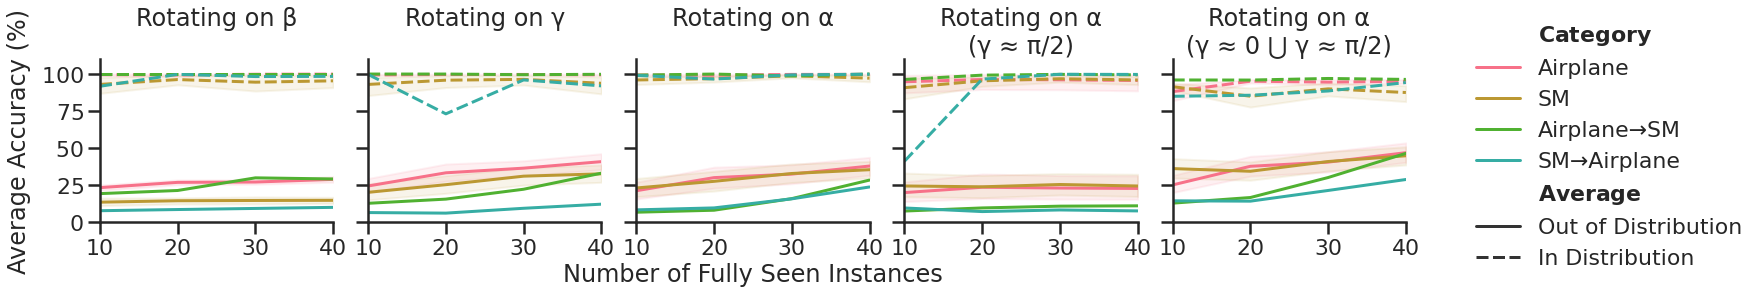

In [6]:
joined = get_joined()
FIGURE_PATH = '/home/avic/Rotation-Generalization/notebooks/figures/averages'
os.makedirs(FIGURE_PATH, exist_ok=True)
FILE_NAME = 'cross'
HUE = 'training_category' #'exp_iter' # 
joined = joined[joined.training_category.isin(['Airplane', 'SM', "Airplane→SM", "SM→Airplane"])]
ROW_ORDER = ['Airplane', 'Car', 'SM'] #["Airplane → SM", "SM → Airplane"]
LEGEND_1_TITLE = 'Category' #r"$\bf{Test \hspace{0.5} Set}$"
LEGEND_2_TITLE = 'Average'
def get_title(title):
    spaces_added = '\hspace{0.5}'.join(title.split(' '))
    return fr"$\bf{spaces_added}$"
sns.set_style("dark")
sns.set_context("poster")
sns.set_style("ticks")
sns.set_palette('husl')
# wes.set_palette('Rushmore1')
# sns.set_palette(np.array(sns.color_palette())[::-1])
melted_joined = pd.melt(joined, id_vars=['job_id', 'data_div', 'num', 'axes_scheme', 'Architecture', 'training_category', 'unrestricted_axis', 'exp_iter', 'exp_type', 'Training Condition'], value_vars=["In Distribution", "Out of Distribution"])
g = sns.FacetGrid(melted_joined, col="axes_scheme", xlim=(10,40), ylim=(0,1.1), margin_titles=True, gridspec_kws={"wspace":0.15, "hspace":0.15}, size=3, aspect=1.5, col_order=[Y, X, Z, HOLE, HOLE_CENTER])
lps = g.map_dataframe(sns.lineplot, "data_div", "value", style='variable', style_order=['Out of Distribution', 'In Distribution'], hue=HUE, hue_order=['Airplane', 'SM', "Airplane→SM", "SM→Airplane"], err_kws={"alpha": .1})
plt.xticks(range(10,50,10))
plt.yticks([0.25 * i for i in range(5)], [f' {25 * i}' for i in range(5)])
[plt.setp(ax.texts, text="") for ax in g.axes.flat]
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
[g.axes[0,x].set_xlabel('' if x != 2 else "Number of Fully Seen Instances") for x in range(5)]
# [g.axes[y,0].set_ylabel('' if y != len(ROW_ORDER) // 2 else "Average Accuracy (%)") for y in range(len(ROW_ORDER))]
g.axes[0,0].set_ylabel("Average Accuracy (%)")
g.add_legend()
g._legend.texts[0].set_text(get_title(LEGEND_1_TITLE))
g._legend.texts[len(melted_joined[HUE].unique()) + 1].set_text(get_title(LEGEND_2_TITLE))
plt.savefig(os.path.join(FIGURE_PATH, f'{FILE_NAME}.png'), dpi=200, bbox_inches='tight')